In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers = 5
input_size = 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa / np.max(alpha) #Normalization

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta) #Normalization
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h) #Normalization

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [21]:
x = np.hstack((aa, total_coords))

In [22]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [23]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [24]:
target_c3 = target_df.iloc[:,4].values # Cl values

In [25]:
cl = target_c3.reshape((-1,1))

In [26]:
y = (cl-np.min(cl))/(np.max(cl)-np.min(cl))

In [27]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [28]:
x_train, x_val, x_test, y_train, y_val, y_test, cd_train, cd_val, cd_test = dataset_split(x, y, cl,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [29]:
x_train.shape

(100, 111)

In [30]:
y_train.shape

(100, 1)

In [45]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=x.shape[1])

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [46]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 111)]             0         
                                                                 
 fc1 (Dense)                 (None, 256)               28672     
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257 

In [47]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [48]:
model_directory = "D:\\TrainedModels\\20221230\\steady_coordinatesOnly"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [49]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, min_delta=1e-06,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1000, factor=0.1,
                                          min_delta = 1e-5, min_lr=1e-05, verbose=1)

In [50]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [51]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/10000
5/5 [==============================] - 5s 108ms/step - loss: 0.3985 - rmse: 0.6312 - val_loss: 0.3837 - val_rmse: 0.6193 - lr: 1.0000e-04
Epoch 2/10000
5/5 [==============================] - 0s 18ms/step - loss: 0.3417 - rmse: 0.5844 - val_loss: 0.3250 - val_rmse: 0.5700 - lr: 1.0000e-04
Epoch 3/10000
5/5 [==============================] - 0s 15ms/step - loss: 0.2879 - rmse: 0.5365 - val_loss: 0.2638 - val_rmse: 0.5135 - lr: 1.0000e-04
Epoch 4/10000
5/5 [==============================] - 0s 15ms/step - loss: 0.2288 - rmse: 0.4782 - val_loss: 0.1973 - val_rmse: 0.4441 - lr: 1.0000e-04
Epoch 5/10000
5/5 [==============================] - 0s 16ms/step - loss: 0.1699 - rmse: 0.4120 - val_loss: 0.1285 - val_rmse: 0.3584 - lr: 1.0000e-04
Epoch 6/10000
5/5 [==============================] - 0s 15ms/step - loss: 0.1063 - rmse: 0.3259 - val_loss: 0.0693 - val_rmse: 0.2630 - lr: 1.0000e-04
Epoch 7/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.0590 - rmse: 0.24

Epoch 55/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0086 - rmse: 0.0922 - val_loss: 0.0176 - val_rmse: 0.1321 - lr: 1.0000e-04
Epoch 56/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0087 - rmse: 0.0925 - val_loss: 0.0187 - val_rmse: 0.1363 - lr: 1.0000e-04
Epoch 57/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0086 - rmse: 0.0920 - val_loss: 0.0179 - val_rmse: 0.1333 - lr: 1.0000e-04
Epoch 58/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0085 - rmse: 0.0918 - val_loss: 0.0170 - val_rmse: 0.1300 - lr: 1.0000e-04
Epoch 59/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0087 - rmse: 0.0928 - val_loss: 0.0166 - val_rmse: 0.1284 - lr: 1.0000e-04
Epoch 60/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0086 - rmse: 0.0919 - val_loss: 0.0186 - val_rmse: 0.1360 - lr: 1.0000e-04
Epoch 61/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0088 - rmse

Epoch 109/10000
5/5 [==============================] - 0s 15ms/step - loss: 0.0085 - rmse: 0.0917 - val_loss: 0.0172 - val_rmse: 0.1307 - lr: 1.0000e-04
Epoch 110/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0085 - rmse: 0.0914 - val_loss: 0.0186 - val_rmse: 0.1360 - lr: 1.0000e-04
Epoch 111/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0085 - rmse: 0.0918 - val_loss: 0.0170 - val_rmse: 0.1298 - lr: 1.0000e-04
Epoch 112/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0084 - rmse: 0.0913 - val_loss: 0.0171 - val_rmse: 0.1302 - lr: 1.0000e-04
Epoch 113/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0085 - rmse: 0.0918 - val_loss: 0.0184 - val_rmse: 0.1352 - lr: 1.0000e-04
Epoch 114/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0084 - rmse: 0.0913 - val_loss: 0.0173 - val_rmse: 0.1312 - lr: 1.0000e-04
Epoch 115/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0088

5/5 [==============================] - 0s 14ms/step - loss: 0.0085 - rmse: 0.0916 - val_loss: 0.0162 - val_rmse: 0.1267 - lr: 1.0000e-04
Epoch 163/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0085 - rmse: 0.0914 - val_loss: 0.0182 - val_rmse: 0.1347 - lr: 1.0000e-04
Epoch 164/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0084 - rmse: 0.0910 - val_loss: 0.0174 - val_rmse: 0.1317 - lr: 1.0000e-04
Epoch 165/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0086 - rmse: 0.0922 - val_loss: 0.0162 - val_rmse: 0.1270 - lr: 1.0000e-04
Epoch 166/10000
5/5 [==============================] - 0s 15ms/step - loss: 0.0084 - rmse: 0.0910 - val_loss: 0.0178 - val_rmse: 0.1329 - lr: 1.0000e-04
Epoch 167/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0086 - rmse: 0.0923 - val_loss: 0.0181 - val_rmse: 0.1342 - lr: 1.0000e-04
Epoch 168/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0086 - rmse: 0.0919 

Epoch 216/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0083 - rmse: 0.0906 - val_loss: 0.0163 - val_rmse: 0.1274 - lr: 1.0000e-04
Epoch 217/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0084 - rmse: 0.0911 - val_loss: 0.0179 - val_rmse: 0.1334 - lr: 1.0000e-04
Epoch 218/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0084 - rmse: 0.0911 - val_loss: 0.0164 - val_rmse: 0.1275 - lr: 1.0000e-04
Epoch 219/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0083 - rmse: 0.0907 - val_loss: 0.0170 - val_rmse: 0.1299 - lr: 1.0000e-04
Epoch 220/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0083 - rmse: 0.0907 - val_loss: 0.0173 - val_rmse: 0.1309 - lr: 1.0000e-04
Epoch 221/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0083 - rmse: 0.0906 - val_loss: 0.0162 - val_rmse: 0.1267 - lr: 1.0000e-04
Epoch 222/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0084

5/5 [==============================] - 0s 14ms/step - loss: 0.0083 - rmse: 0.0906 - val_loss: 0.0175 - val_rmse: 0.1318 - lr: 1.0000e-04
Epoch 270/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0084 - rmse: 0.0910 - val_loss: 0.0164 - val_rmse: 0.1278 - lr: 1.0000e-04
Epoch 271/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0082 - rmse: 0.0902 - val_loss: 0.0173 - val_rmse: 0.1311 - lr: 1.0000e-04
Epoch 272/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0083 - rmse: 0.0905 - val_loss: 0.0172 - val_rmse: 0.1308 - lr: 1.0000e-04
Epoch 273/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0090 - rmse: 0.0941 - val_loss: 0.0158 - val_rmse: 0.1254 - lr: 1.0000e-04
Epoch 274/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0083 - rmse: 0.0903 - val_loss: 0.0195 - val_rmse: 0.1393 - lr: 1.0000e-04
Epoch 275/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0087 - rmse: 0.0929 

Epoch 323/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0096 - rmse: 0.0977 - val_loss: 0.0185 - val_rmse: 0.1355 - lr: 1.0000e-04
Epoch 324/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0094 - rmse: 0.0965 - val_loss: 0.0140 - val_rmse: 0.1179 - lr: 1.0000e-04
Epoch 325/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0097 - rmse: 0.0979 - val_loss: 0.0215 - val_rmse: 0.1464 - lr: 1.0000e-04
Epoch 326/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0088 - rmse: 0.0934 - val_loss: 0.0170 - val_rmse: 0.1301 - lr: 1.0000e-04
Epoch 327/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0083 - rmse: 0.0904 - val_loss: 0.0162 - val_rmse: 0.1269 - lr: 1.0000e-04
Epoch 328/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0083 - rmse: 0.0903 - val_loss: 0.0173 - val_rmse: 0.1310 - lr: 1.0000e-04
Epoch 329/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0084

5/5 [==============================] - 0s 14ms/step - loss: 0.0082 - rmse: 0.0900 - val_loss: 0.0166 - val_rmse: 0.1285 - lr: 1.0000e-04
Epoch 377/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0086 - rmse: 0.0921 - val_loss: 0.0164 - val_rmse: 0.1275 - lr: 1.0000e-04
Epoch 378/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0088 - rmse: 0.0931 - val_loss: 0.0199 - val_rmse: 0.1408 - lr: 1.0000e-04
Epoch 379/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0085 - rmse: 0.0918 - val_loss: 0.0154 - val_rmse: 0.1236 - lr: 1.0000e-04
Epoch 380/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0083 - rmse: 0.0907 - val_loss: 0.0172 - val_rmse: 0.1310 - lr: 1.0000e-04
Epoch 381/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0082 - rmse: 0.0898 - val_loss: 0.0172 - val_rmse: 0.1306 - lr: 1.0000e-04
Epoch 382/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0083 - rmse: 0.0904 

Epoch 430/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0083 - rmse: 0.0904 - val_loss: 0.0180 - val_rmse: 0.1337 - lr: 1.0000e-04
Epoch 431/10000
5/5 [==============================] - 0s 16ms/step - loss: 0.0082 - rmse: 0.0902 - val_loss: 0.0165 - val_rmse: 0.1280 - lr: 1.0000e-04
Epoch 432/10000
5/5 [==============================] - 0s 15ms/step - loss: 0.0084 - rmse: 0.0910 - val_loss: 0.0156 - val_rmse: 0.1245 - lr: 1.0000e-04
Epoch 433/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0081 - rmse: 0.0893 - val_loss: 0.0180 - val_rmse: 0.1339 - lr: 1.0000e-04
Epoch 434/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0084 - rmse: 0.0909 - val_loss: 0.0185 - val_rmse: 0.1356 - lr: 1.0000e-04
Epoch 435/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0087 - rmse: 0.0928 - val_loss: 0.0154 - val_rmse: 0.1238 - lr: 1.0000e-04
Epoch 436/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0084

5/5 [==============================] - 0s 13ms/step - loss: 0.0081 - rmse: 0.0892 - val_loss: 0.0183 - val_rmse: 0.1348 - lr: 1.0000e-04
Epoch 484/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0081 - rmse: 0.0895 - val_loss: 0.0172 - val_rmse: 0.1309 - lr: 1.0000e-04
Epoch 485/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0080 - rmse: 0.0891 - val_loss: 0.0165 - val_rmse: 0.1279 - lr: 1.0000e-04
Epoch 486/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0080 - rmse: 0.0891 - val_loss: 0.0163 - val_rmse: 0.1273 - lr: 1.0000e-04
Epoch 487/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0081 - rmse: 0.0894 - val_loss: 0.0183 - val_rmse: 0.1349 - lr: 1.0000e-04
Epoch 488/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0082 - rmse: 0.0900 - val_loss: 0.0166 - val_rmse: 0.1286 - lr: 1.0000e-04
Epoch 489/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0080 - rmse: 0.0892 

Epoch 537/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0082 - rmse: 0.0902 - val_loss: 0.0158 - val_rmse: 0.1254 - lr: 1.0000e-04
Epoch 538/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0079 - rmse: 0.0886 - val_loss: 0.0190 - val_rmse: 0.1375 - lr: 1.0000e-04
Epoch 539/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0081 - rmse: 0.0893 - val_loss: 0.0166 - val_rmse: 0.1285 - lr: 1.0000e-04
Epoch 540/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0081 - rmse: 0.0897 - val_loss: 0.0163 - val_rmse: 0.1272 - lr: 1.0000e-04
Epoch 541/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0079 - rmse: 0.0886 - val_loss: 0.0181 - val_rmse: 0.1341 - lr: 1.0000e-04
Epoch 542/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0081 - rmse: 0.0893 - val_loss: 0.0171 - val_rmse: 0.1303 - lr: 1.0000e-04
Epoch 543/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0080

5/5 [==============================] - 0s 14ms/step - loss: 0.0080 - rmse: 0.0890 - val_loss: 0.0170 - val_rmse: 0.1302 - lr: 1.0000e-04
Epoch 591/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0078 - rmse: 0.0881 - val_loss: 0.0162 - val_rmse: 0.1271 - lr: 1.0000e-04
Epoch 592/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0080 - rmse: 0.0888 - val_loss: 0.0179 - val_rmse: 0.1336 - lr: 1.0000e-04
Epoch 593/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0079 - rmse: 0.0886 - val_loss: 0.0165 - val_rmse: 0.1282 - lr: 1.0000e-04
Epoch 594/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0080 - rmse: 0.0890 - val_loss: 0.0173 - val_rmse: 0.1311 - lr: 1.0000e-04
Epoch 595/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0081 - rmse: 0.0894 - val_loss: 0.0170 - val_rmse: 0.1299 - lr: 1.0000e-04
Epoch 596/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0078 - rmse: 0.0878 

In [52]:
time = end - start
print("Training time:", time)

Training time: 0:00:45.798691


In [53]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221230_MLP_Steady_coordinatesOnly\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_ClPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

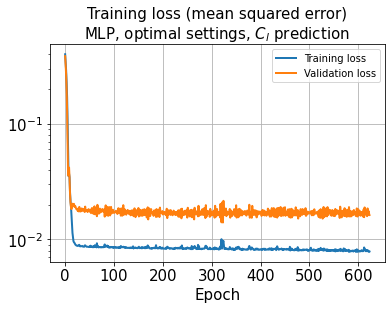

In [54]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_l$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

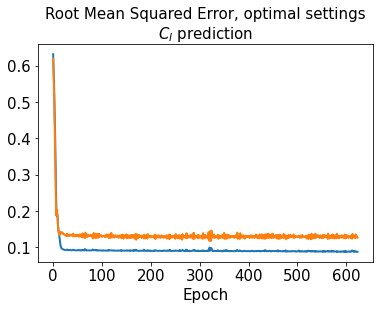

In [55]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_l$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

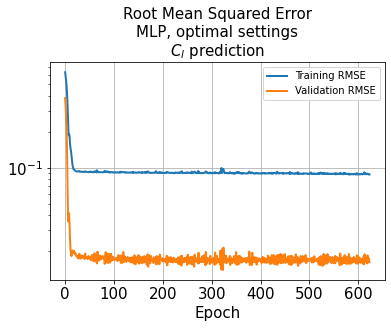

In [56]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_l$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [57]:
train_results = model.evaluate(x_train, y_train)

4/4 [==============================] - 0s 4ms/step - loss: 0.0096 - rmse: 0.0977


In [58]:
test_results = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 20ms/step - loss: 0.0099 - rmse: 0.0988


In [59]:
model_directory = "D:\\TrainedModels\\20221230"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221230steady_MLP_coordinates_test"+str(test_rate)+ "_" + str(n_units) +"units_Clonly.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [60]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [61]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [62]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cl)-np.min(cl))+np.min(cl)

In [63]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [64]:
index_train = define_index(cl, y_train)
index_val = define_index(cl, y_val)
index_test = define_index(cl, y_test)

In [65]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

1/1 [==============================] - 0s 16ms/step


In [66]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [67]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.15001503430166088
6.86356471818032


In [68]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.1803171654621182
7.918966582143257


In [69]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.13766675289223151
6.3506238173940055


In [70]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [71]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [72]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [73]:
os.chdir(storage_dir)

In [74]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [75]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [76]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [77]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [78]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [79]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [80]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, steady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_l$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

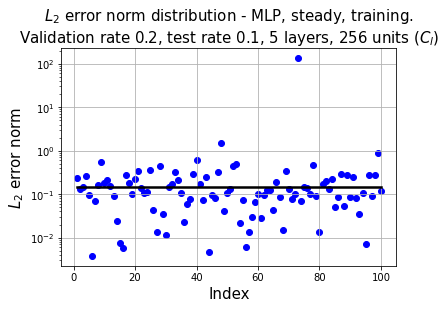

In [81]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

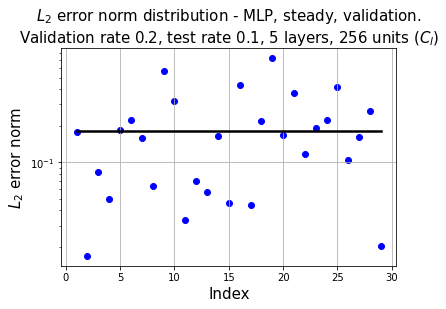

In [82]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

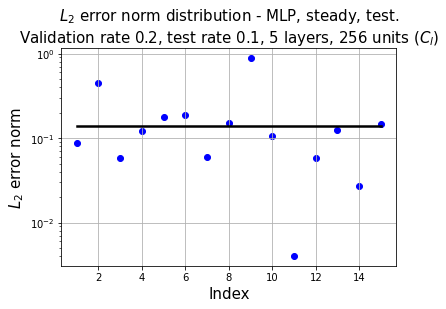

In [83]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [84]:
predicted = model.predict(x)

5/5 [==============================] - 0s 2ms/step


In [85]:
l2_error(predicted, y)

0.15515616431579296

In [86]:
l2_error(denormalize(predicted), denormalize(y))

0.1549248438911132

In [87]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [88]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [89]:
iTrain

array([[0.07829523],
       [0.32026658],
       [0.64085304],
       [0.79504709],
       [0.22453571],
       [0.46498353],
       [0.67395674],
       [0.81310017],
       [0.11326874],
       [0.24039666],
       [0.36464193],
       [0.69343918],
       [0.7750257 ],
       [0.82894226],
       [0.12056524],
       [0.24830382],
       [0.37246021],
       [0.49178494],
       [0.60378922],
       [0.70364091],
       [0.78497435],
       [0.83728118],
       [0.12068746],
       [0.248154  ],
       [0.37238232],
       [0.49109551],
       [0.60168919],
       [0.83380317],
       [0.27531911],
       [0.39837455],
       [0.51306285],
       [0.62341214],
       [0.72053083],
       [0.8019807 ],
       [0.85555728],
       [0.8531834 ],
       [0.18051965],
       [0.43777075],
       [0.55813943],
       [0.67045249],
       [0.89760389],
       [0.88764759],
       [0.20359172],
       [0.33557902],
       [0.46343644],
       [0.58501354],
       [0.69819459],
       [0.798

In [90]:
aa = aa*16

In [91]:
aa = np.ceil(aa)

In [92]:
def CL_trainTestSplit_Plot(i, CL, cl, aTrain, aVal, aTest, iTrain, iVal, iTest):
    
    #title_0_Cd = 'Gurney flap not attached (NACA0018)\n$C_D$ prediction, L2 error=%.4f' % l2_error_Cd
    title_0_Cl = 'Gurney flap not attached (NACA0018)\n$C_L$ prediction (normalized), L2 error=%.4f' % l2_error_Cl
    
    #title_n_Cd = 'Gurney flap attached h=%.2f, beta=%d\nCD prediction, L2 error=%.4f'%(h[i], beta[i],l2_error_Cd)
    title_n_Cl = 'Gurney flap attached h=%.2f, beta=%d\nCL prediction (normalized), L2 error=%.4f'%(h[i], beta[i], l2_error_Cl)
    
    if i==0:
        title_Cl = title_0_Cl
        savename2 =  "ClComparison_NACA0018.jpg"
    else:
        title_Cl = title_n_Cl
        #savename1 = "CdComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
        savename2 = "ClComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    '''
    # CD graph plot
    plt.plot(alpha, CD, 'k-', label='Ground truth')
    plt.plot(alpha, cd, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain[:,0]/10, color='b', label='Training set')
    plt.scatter(aTest, iTest[:,0]/10, color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_D$')
    plt.title(title_Cd, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([0, 0.12])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
'''
    # CL graph plot
    plt.plot(alpha, denormalize(CL), 'k-', label='Ground truth')
    plt.plot(alpha, denormalize(cl), 'k--', label='Predicted value')
    plt.scatter(aTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(aVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(aTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_L$ (normalized)')
    plt.title(title_Cl, fontsize=15)
    plt.legend(loc='upper left')
    plt.ylim([0, 1])
    plt.grid()
    plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

NACA0018 airfoil without Gurney flap
L2 error of Cl: 0.1286


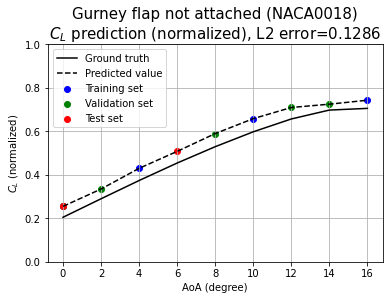

L2 error of Cl: 0.0802


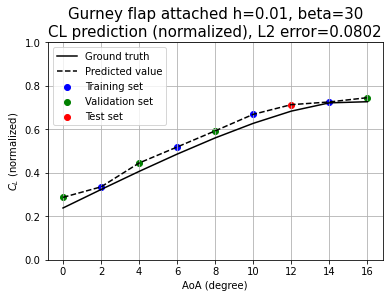

L2 error of Cl: 0.0443


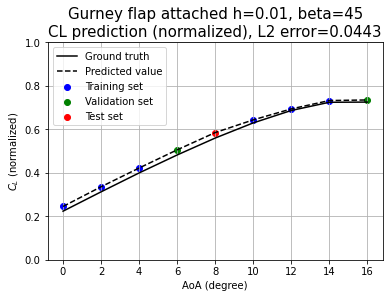

L2 error of Cl: 0.0399


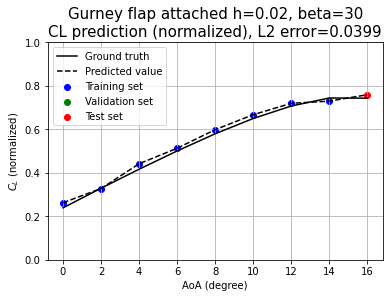

L2 error of Cl: 0.0416


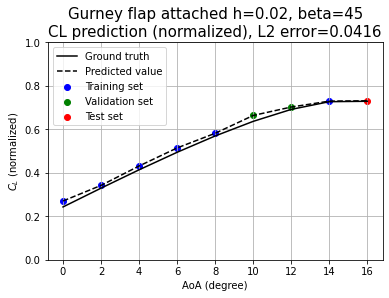

L2 error of Cl: 0.0256


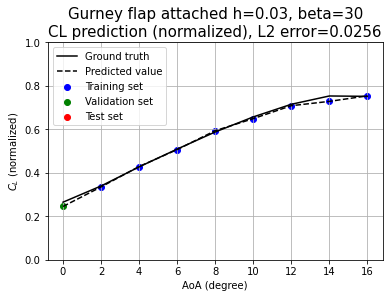

L2 error of Cl: 0.0733


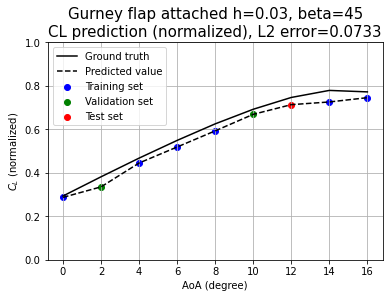

L2 error of Cl: 0.1045


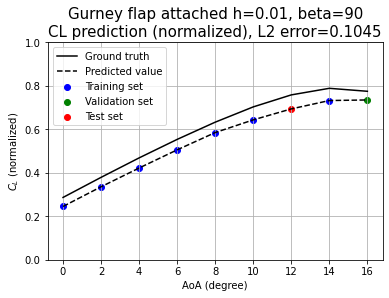

L2 error of Cl: 0.1183


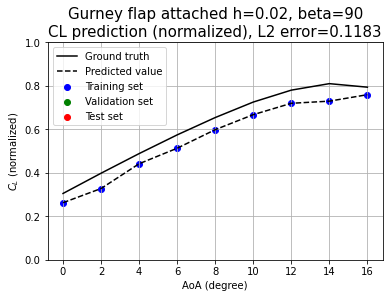

L2 error of Cl: 0.1100


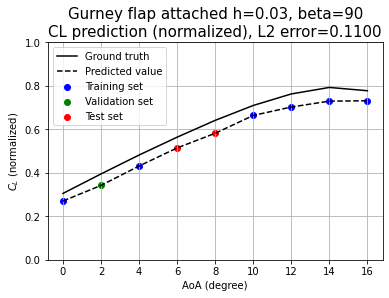

L2 error of Cl: 0.1083


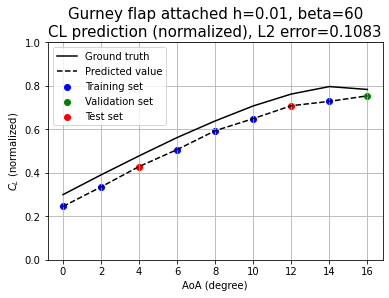

L2 error of Cl: 0.1628


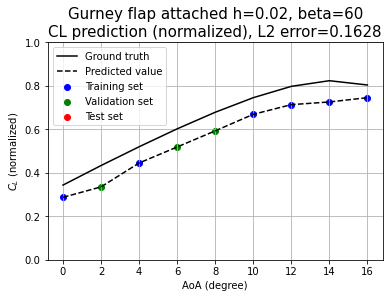

L2 error of Cl: 0.1941


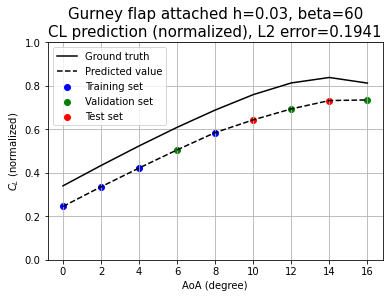

L2 error of Cl: 0.2052


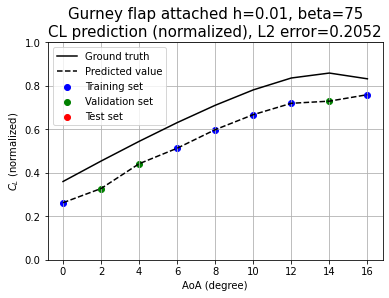

L2 error of Cl: 0.1985


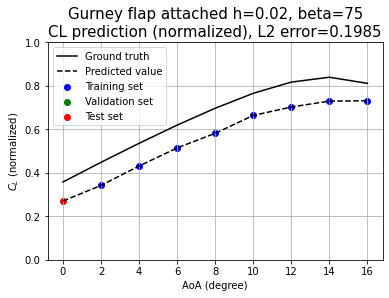

L2 error of Cl: 0.5409


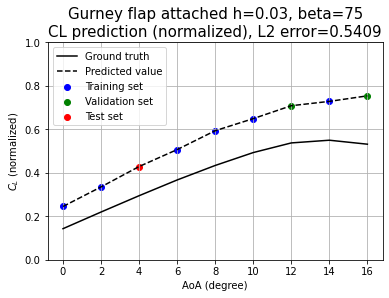

In [93]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]


for i in range(0, 16):
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    predictedValue = predicted[n_alpha*i:n_alpha*(i+1),:]
    y_corres = y[n_alpha*i:n_alpha*(i+1),:]
    
    #l2_error_Cd = np.sqrt(np.sum((predictedValue[:,0] - y_corres[:,0])**2) / np.sum(y_corres[:,0]**2))
    l2_error_Cl = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cl: {0:0.4f}'.format(l2_error_Cl))
    else:
        print('L2 error of Cl: {0:0.4f}'.format(l2_error_Cl))
    
    cl = predicted[n_alpha*i:n_alpha*(i+1),:]
    #cd = predicted[n_alpha*i:n_alpha*(i+1),0]/10
    
    CL = y[n_alpha*i:n_alpha*(i+1),:]
    #CD = y[n_alpha*i:n_alpha*(i+1),0]/10
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest_.append(predicted[index])
        
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    alpha_train = []
    alpha_val = []
    alpha_test = []
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    for ii, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        alpha_val.append(aa[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)
    aVal = np.array(alpha_val)
    aTest = np.array(alpha_test)
    
    CL_trainTestSplit_Plot(i, CL, cl, aTrain, aVal, aTest, iTrain_, iVal_, iTest_)